In [1]:
                                                # IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import ccxt
import datetime as dt
import seaborn as sns
import yfinance as yf

                                                    # CREATING THE RESULTS DIRECTORY FOR THE PROBLEMS SETS 
results_dir='RESULTS_WEEK_2'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)



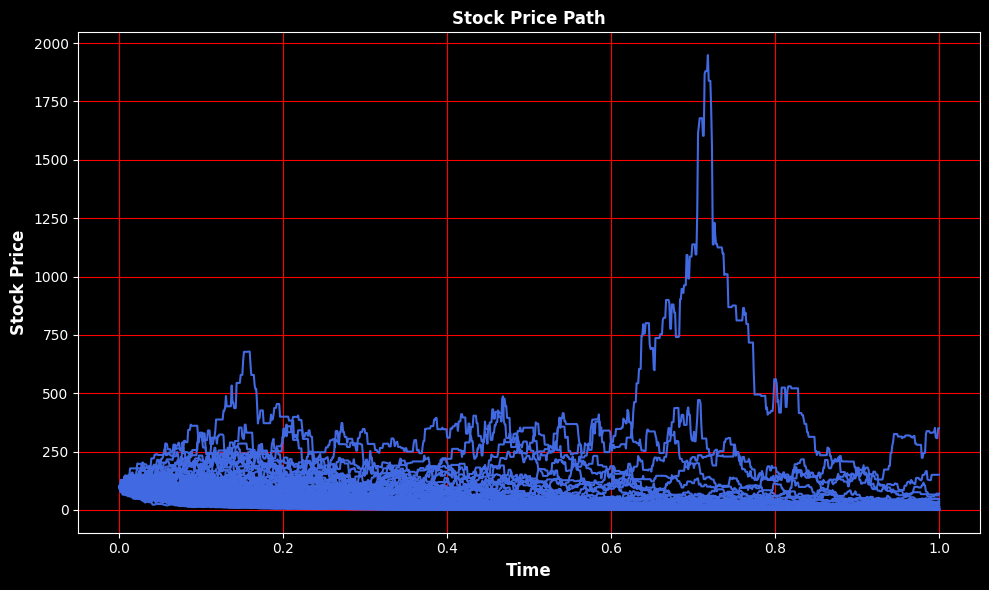

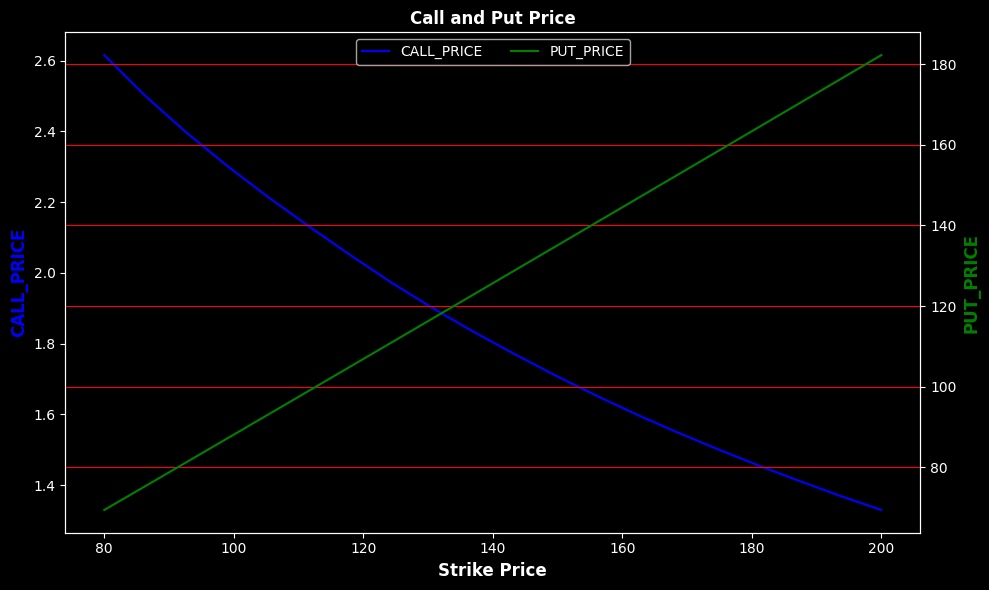

In [ ]:
                                    # DAY 1 MERTON JUMP MODEL WITH POISSON JUMPS AND MONTE CARLO PRICING FOR OPTIONS
        
                                    
                                        # INITIALIZING THE IMPORTANT PARAMTERS 
S_0=100                                 # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                     # 5% RISK FREE T_BILL RATE
VOLATILITY_STOCK=0.20                   # VOLATILITY OF STOCK
STRIKES=np.linspace(80,200,20)          # STRIKE VALUES
DURATION=1                              # TIME TO Maturity
Nofpaths=10000                          # NUMBER OF PATHS
Nofsteps=1000                           # Number of time steps
LAMBDA=0.5                              # poisson jump intensity
JUMP_MEAN=-0.0108                       # JUMP MAGNITUDE MEAN
JUMP_VOLATILTITY=0.10                   # JUMP MAGNITUDE VOLAITILTY
PRICES=pd.DataFrame(index=STRIKES)      # STRIKE PRICE DATAFRAME
EPSILON=1e-4                            # LOWER BOUND SCALE FACTOR FOR THE STOCK PRICE FOR THE DIFFUSION MODEL
day_result='JUMP_DIFFUSION_MERTON_MODEL'# DAY 1 RESULTS DIRECTORY

''' MODEL CHARACTERISTICS
1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS 
2) THE JUMP SIZE IS A RANDOM NORMAL  VARIABLE WITH A GIVEN MEAN AND VOLATILITY
3) THE JUMP SIZE IS NOT CORRELATED WITH THE STOCK PRICE MOVEMENTS
4) THE VOLATILITY AND THE JUMP PARAMTERS AND NON STOCHASTIC 
5) THE METHOD FOR PATH GENERATION WILL BE EULER DISCRETISATION
6) THE JUMP PARAMETERS ARE SET TO SIMULATE STOCK CRASH SCENARIOS
'''
                                            # CREATE THE RESULTS DIRECTORY CONCATENATED WITHE MAIN RESULTS DIRECTPRY
fold_path=os.path.join(results_dir,day_result)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)

                                            # PATH GENERATION FUNCTION


def Path_Generation(INITIAL_STOCK,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON=1e-4):
    STOCK_PATHS=np.zeros((Nofpaths,Nofsteps+1))
    z=np.random.randn(Nofpaths,Nofsteps)
    STOCK_PATHS[:,0]=INITIAL_STOCK
    dt=DURATION/Nofsteps
    poisson=np.random.poisson(LAMBDA,size=(Nofpaths,Nofsteps))
    poisson=np.where(poisson>0,1,0)
    jump_mag=np.random.normal(JUMP_MEAN,JUMP_VOLATILTITY,size=(Nofpaths,Nofsteps))
    time=[i*dt for i in range(Nofsteps+1)]
    PARAMTERS={}
    for I in range(Nofsteps):
        z[:,I]=(z[:,I]-np.mean(z[:,I]))/(np.std(z[:,I]))
        STOCK_PATHS[:,I+1]=STOCK_PATHS[:,I] + STOCK_PATHS[:,I]*(RISK_FREE_RATE-LAMBDA*(np.mean(np.exp(jump_mag[:,I]))-1))*dt + VOLATILITY_STOCK*z[:,I]*np.sqrt(dt) + STOCK_PATHS[:,I]*(np.exp(jump_mag[:,I])-1)*poisson[:,I]
        STOCK_PATHS[:,I+1]=np.maximum(STOCK_PATHS[:,I+1],EPSILON*(-STOCK_PATHS[:,I+1])) 
        
    PARAMTERS['PATHS']=STOCK_PATHS
    PARAMTERS['TIME']=time
    PARAMTERS['POISSON_MATRIX']=poisson
    PARAMTERS['JUMP_MAGNITUDE_MATRIX']=jump_mag
    PARAMTERS['STOCK_MATURITY']=STOCK_PATHS[:,-1]
    return PARAMTERS

                                            #INITIALISING THE STOCK PATHS AND TIME STAMPS AND STORING THEM UN THE PARATERS VARIABLE TO AVOID LOOPING AND COMPUATATIONAL TIME 

parameters=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)



                                            # DEFINING THE MONTE CARLO PRICING FUNCTION
def monte_carlo_pricing(type,INITIAL_STOCK,STRIKE,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters):
     
     S_T=parameters['STOCK_MATURITY']
     type=type.lower()
     if type=='call':
         price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T-STRIKE,0))
     elif type=='put':
        price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(STRIKE-S_T,0))
     return price
    
PRICES['CALL_PRICE']=[monte_carlo_pricing('call',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES['PUT_PRICE']=[monte_carlo_pricing('put',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES.index.name='STRIKE PRICE'
FILE_PATH=os.path.join(fold_path,'MERTON_JUMP_MODEL_PRICES.csv')
PRICES.to_csv(FILE_PATH)



                                                # PLOTTING THE STOCK PATHS AND THE CALL AND PUT PRICES

                                               
                                               
                                               
                                                # plotting the simulated stock price paths  first 100 sample paths
PARAMETERS=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths)
PATHS=PARAMETERS['PATHS']
TIME=PARAMETERS['TIME']

fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

for i in range(100):
    ax.plot(TIME,PATHS[i,:],color='royalblue')   
ax.set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax.set_ylabel('Stock Price',fontdict={'weight':'bold','size':12})
ax.set_title('Stock Price Path',fontdict={'weight':'bold','size':12})

plt.grid(True,color='r',linestyle='-')
fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_STOCK_PATHS.png')
plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()

                                                
                                                
                                                
                                                # plotting the call and put prices
fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

ax.plot(STRIKES,PRICES['CALL_PRICE'],color='blue',label='CALL_PRICE')
ax.set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax.set_ylabel('CALL_PRICE',fontdict={'weight':'bold','size':12},color='blue')


ax1=ax.twinx()
ax1.plot(STRIKES,PRICES['PUT_PRICE'],color='GREEN',label='PUT_PRICE')
ax1.set_ylabel('PUT_PRICE',fontdict={'weight':'bold','size':12},color='green')

lines1,labels1= ax.get_legend_handles_labels()
lines2,labels2= ax1.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='upper center',frameon=True,ncol=2,fontsize=10)


plt.title('Call and Put Price',fontdict={'weight':'bold','size':12})
plt.grid(True,color='r',linestyle='-')


fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_CALL_PUT_PRICES.png')

plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()
                                                                        



C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_10576\1503646971.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


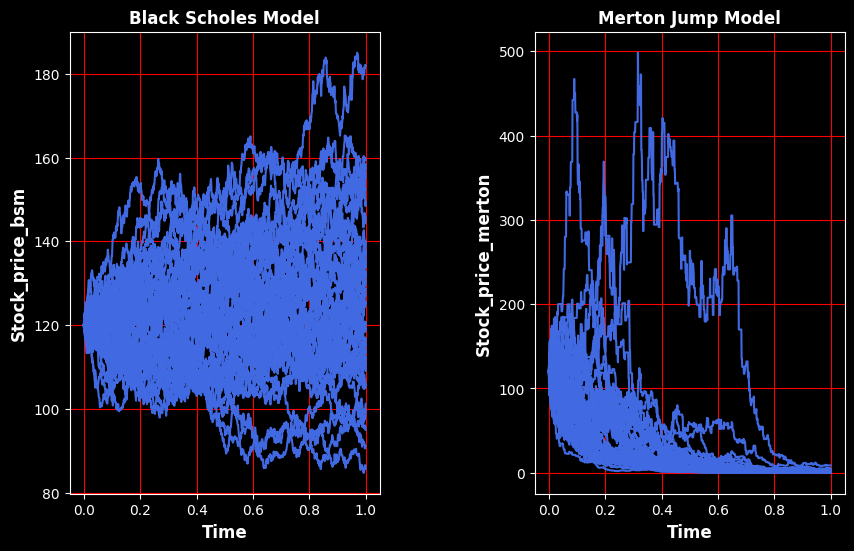

C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_10576\1503646971.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


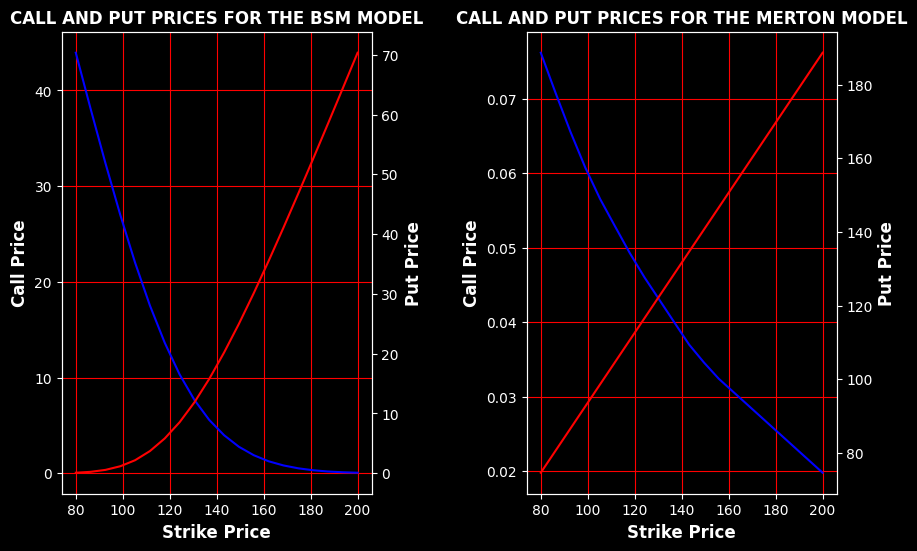

C:\Users\ABILFAZAL UNWALA\AppData\Local\Temp\ipykernel_10576\1503646971.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


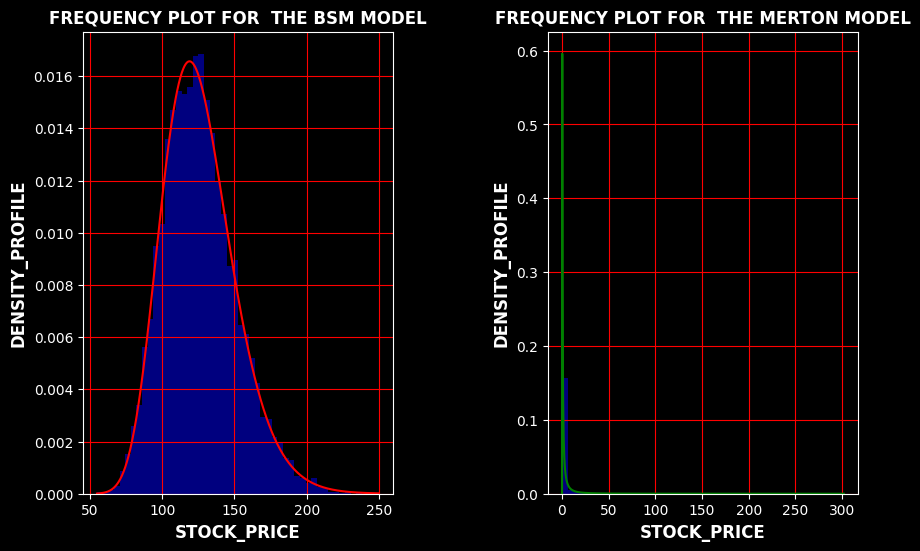

In [ ]:
                    # DAY 3 PROBLEM COMPARITIVE ANALYSIS OF MERTON JUMP MODEL AND BLACK SCHOLES MODEL
                    
                                
                                
                                # CREATING THE RESULTS DIRECTORY FOR THE PROBLEMS SETS
DAY_RESULTS_DIR = 'COMPARITIVE_ANALYSIS_MERTON_JUMP_MODEL_AND_BLACK_SCHOLES_MODEL'
fold_path=os.path.join(results_dir,DAY_RESULTS_DIR)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)


'''MODEL CHARACTERISTICS:

1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS
2) THE JUMP SIZE IS A RANDOM NORMAL  VARIABLE WITH A GIVEN MEAN AND VOLATILITY
3) THE BLACK SHCOLES MODEL IS PRICED USING THE DIFFUSION MODEL MONTE CARLO PRICING
4) THE JUMP SIZE IS NOT CORRELATED WITH THE STOCK PRICE MOVEMENTS
5) COMPARATIVE ANALYSIS OF THE JUMP MODEL AND THE BLACK SCHOLES MODEL IS PERFROMED FOR A RANGE OF STRIKES
6) THE VOLATILITY AND THE JUMP PARAMTERS ARE  NON STOCHASTIC

'''
# DEFINING THE INPUT PARAMTERS FOR THE COMPARATIVE ANAYLIS MODEL
S_0=120                                # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                     # 5% RISK FREE T_BILL RATE
VOLATILITY_STOCK=0.20                   # VOLATILITY OF STOCK
STRIKES=np.linspace(80,200,20)          # STRIKE VALUES
DURATION=1                              # TIME TO Maturity
Nofpaths=10000                          # NUMBER OF PATHS
Nofsteps=1000                           # Number of time steps
LAMBDA=0.5                             # poisson jump intensity
JUMP_MEAN=-0.0148                       # JUMP MAGNITUDE MEAN
JUMP_VOLATILTITY=0.0850                   # JUMP MAGNITUDE VOLAITILTY
EPSILON=1e-4                            # LOWER BOUND SCALE FACTOR  FOR THE STOCK IN JUMP MODEL
QUANTITATIVE_INFERENCE=pd.DataFrame(
    index=STRIKES)                      # INITIALISING THE RESULTS DATAFRAME FOR THE QUANTITATIVE INFERENCE                                  
                                
                                
                                
                                
                                
                                # DEFINING THE PATH GENERATION FUNCTION FOR THE BLACK SCHOLES MODEL
def Path_Generation_BS(INITIAL_STOCK,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths):
    STOCK_PATHS=np.zeros((Nofpaths,Nofsteps+1))
    z=np.random.randn(Nofpaths,Nofsteps)
    STOCK_PATHS[:,0]=INITIAL_STOCK
    dt=DURATION/Nofsteps
    time=[i*dt for i in range(Nofsteps+1)]
    parameters={}
    for I in range(Nofsteps):
        z[:,I]=(z[:,I]-np.mean(z[:,I]))/(np.std(z[:,I]))
        STOCK_PATHS[:,I+1]=STOCK_PATHS[:,I] + STOCK_PATHS[:,I]*(RISK_FREE_RATE)*dt + VOLATILITY_STOCK*z[:,I]*np.sqrt(dt)*STOCK_PATHS[:,I]
    parameters['PATHS']=STOCK_PATHS
    parameters['TIME']=time
    parameters['STOCK_MATURITY']=STOCK_PATHS[:,-1]
       
        
    return parameters

                                                # INIITILIZING THE STOCK PATHS AND TIME STAMPS FOR BLACK SCHOLES MODEL BY CALLING THE ABOVE FUCNTION

parameters_bs=Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)

                                                # INITIALISING THE STOCK PATHS AND TIME STAMPS FOR JUMP MODEL BY CALLING THE FUCNTION FROM THE PENULTIMATE CELL
parameters_merton=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)

                                
                                                # DEFINING THE MONTE CARLO PRICING FUCNTION FOR THE TWO MODELS AND OPTIONS
def monte_carlo_pricing(model,type,strike,RISK_FREE_RATE,DURATION,parameters_bsm,parameters_merton):
    model=model.lower()
    type=type.lower()
    S_T_bsm=parameters_bsm['STOCK_MATURITY']
    S_T_merton=parameters_merton['STOCK_MATURITY']
    if model=='bsm':
        if type=='call':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T_bsm-strike,0))
        elif type=='put':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(strike-S_T_bsm,0))
    elif model=='merton':
        if type=='call':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T_merton-strike,0))
        elif type=='put':
            price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(strike-S_T_merton,0))

    return price


                                                # PRICING THE CALL AND PUT OPTIONS FOR THE TWO MODELS AND STORING THEM IN THE QUANTITATIVE INFERENCE DATAFRAME 

QUANTITATIVE_INFERENCE['CALL_PRICE_BSM']=[monte_carlo_pricing('bsm','call',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['PUT_PRICE_BSM']=[monte_carlo_pricing('bsm','put',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['CALL_PRICE_MERTON']=[monte_carlo_pricing('merton','call',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE['PUT_PRICE_MERTON']=[monte_carlo_pricing('merton','put',strike,RISK_FREE_RATE,DURATION,parameters_bs,parameters_merton) for strike in STRIKES]
QUANTITATIVE_INFERENCE.index.name='STRIKE PRICE'
QUANTITATIVE_INFERENCE['BSM_KURTOSIS']=[stats.kurtosis(Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['BSM_SKEWNESS']=[stats.skew(Path_Generation_BS(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,Nofsteps,Nofpaths)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['MERTON_KURTOSIS']=[stats.kurtosis(Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)['STOCK_MATURITY']) for I in range(len(STRIKES))]
QUANTITATIVE_INFERENCE['MERTON_SKEWNESS']=[stats.skew(Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,EPSILON)['STOCK_MATURITY']) for I in range(len(STRIKES))]
                                                
                                                
                                                
                                                # PLOTTING THE DIFFSUSION  AND MERTON JUMP MODEL STOCK PATHS 

fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')
paths_bsm=parameters_bs['PATHS']
paths_merton=parameters_merton['PATHS']
time=parameters_bs['TIME']

for i in range(50):
    ax[0].plot(time,paths_bsm[i,:],color='royalblue')
    ax[1].plot(time,paths_merton[i,:],color='royalblue')

ax[0].set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('Stock_price_bsm',fontdict={'weight':'bold','size':12})
ax[1].set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('Stock_price_merton',fontdict={'weight':'bold','size':12})
ax[0].set_title('Black Scholes Model',fontdict={'weight':'bold','size':12})
ax[1].set_title('Merton Jump Model',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')
ax[1].grid(True,color='r',linestyle='-')
FILE_PATH=os.path.join(fold_path,'DIFFUSION_AND_JUMP_MODEL_STOCK_PATHS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()

                                    
                                        
                                    
                                    # PLOTTING THE CALL AND PUT PRICES FOR THE TWO MODELS

fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')

ax[0].plot(STRIKES,QUANTITATIVE_INFERENCE['CALL_PRICE_BSM'],color='blue',label='CALL_PRICE_BSM')
ax1=ax[0].twinx()
ax1.plot(STRIKES,QUANTITATIVE_INFERENCE['PUT_PRICE_BSM'],color='red',label='PUT_PRICE_BSM')
ax[0].set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('Call Price',fontdict={'weight':'bold','size':12})
ax1.set_ylabel('Put Price',fontdict={'weight':'bold','size':12})
ax[0].set_title('CALL AND PUT PRICES FOR THE BSM MODEL',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')

ax[1].plot(STRIKES,QUANTITATIVE_INFERENCE['CALL_PRICE_MERTON'],color='blue',label='CALL_PRICE_MERTON')
ax2=ax[1].twinx()
ax2.plot(STRIKES,QUANTITATIVE_INFERENCE['PUT_PRICE_MERTON'],color='red',label='PUT_PRICE_MERTON')
ax[1].set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('Call Price',fontdict={'weight':'bold','size':12})
ax2.set_ylabel('Put Price',fontdict={'weight':'bold','size':12})
ax[1].set_title('CALL AND PUT PRICES FOR THE MERTON MODEL',fontdict={'weight':'bold','size':12})
ax[1].grid(True,color='r',linestyle='-')    

FILE_PATH=os.path.join(fold_path,'CALL_AND_PUT_PRICES_FOR_THE_MODELS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()

                    
                    
                    
                    # PLOTTING THE STOCK AT MATURIRY FREQUENCY PLOTS WITH ESTIMATED DENSITY FUCNTION FROM THE GIVEN DATA FOR THE TWO MODELS 
fig,ax=plt.subplots(1,2,figsize=(10,6),gridspec_kw={'hspace':0.3,'wspace':0.5})
plt.style.use('dark_background')

ST_BSM=parameters_bs['STOCK_MATURITY']
ST_MERTON=parameters_merton['STOCK_MATURITY']
shape_bsm,loc_bsm,scale_bsm=stats.lognorm.fit(ST_BSM,floc=0)
shape_merton,loc_merton,scale_merton=stats.lognorm.fit(ST_MERTON,floc=0)
x_bsm=np.linspace(ST_BSM.min(),ST_BSM.max(),1000)
x_merton=np.linspace(ST_MERTON.min(),ST_MERTON.max(),1000)
y_bsm=stats.lognorm.pdf(x_bsm,shape_bsm,loc_bsm,scale_bsm)
y_merton=stats.lognorm.pdf(x_merton,shape_merton,loc_merton,scale_merton)

ax[0].hist(ST_BSM,bins=50,density=True,color='blue',alpha=0.5)
ax[0].plot(x_bsm,y_bsm,color='red')
ax[0].set_xlabel('STOCK_PRICE',fontdict={'weight':'bold','size':12})
ax[0].set_ylabel('DENSITY_PROFILE',fontdict={'weight':'bold','size':12})
ax[0].set_title('FREQUENCY PLOT FOR  THE BSM MODEL',fontdict={'weight':'bold','size':12})
ax[0].grid(True,color='r',linestyle='-')

ax[1].hist(ST_MERTON,bins=50,density=True,color='blue',alpha=0.5)
ax[1].plot(x_merton,y_merton,color='green')
ax[1].set_xlabel('STOCK_PRICE',fontdict={'weight':'bold','size':12})
ax[1].set_ylabel('DENSITY_PROFILE',fontdict={'weight':'bold','size':12})
ax[1].set_title('FREQUENCY PLOT FOR  THE MERTON MODEL',fontdict={'weight':'bold','size':12})
ax[1].grid(True,color='r',linestyle='-')

FILE_PATH=os.path.join(fold_path,'FREQUENCY_PLOT_FOR_THE_MODELS.png')
plt.tight_layout()
plt.savefig(FILE_PATH,bbox_inches='tight',dpi=300)
plt.show()



